In [1]:
import tf_keras as keras
print(keras.__version__)


2.18.0


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
from transformers import BartTokenizer, BartForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification,AdamW, Trainer, TrainingArguments
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score
from torch.utils.data import DataLoader
from torch.nn import functional as F

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [4]:

# BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  # 3 labels: positive, negative, neutral


def preprocess_text(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=128)

texts = ["I love this product!", "This is the worst experience ever.", "It's okay, neither good nor bad."]

def predict_sentiment(texts):
    inputs = preprocess_text(texts)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
    return predictions

predictions=predict_sentiment(texts)

true_labels=torch.tensor([2, 0, 1]) 


# Fine-tuning the model with custom data (optional, assumes you have train and eval datasets)
from datasets import load_dataset
dataset = load_dataset("glue", "sst2")
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]

def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset = eval_dataset.map(tokenize_function, batched=True)


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=lambda p: {
        'accuracy': accuracy_score(p.predictions, p.label_ids),
        'precision': precision_score(p.predictions, p.label_ids, average='weighted'),
        'recall': recall_score(p.predictions, p.label_ids, average='weighted'),
        'f1': f1_score(p.predictions, p.label_ids, average='weighted')
    }
)

# Finetuning the model
trainer.train()

texts=["I love this product!", "This is the worst experience ever.", "It's okay, neither good nor bad."]
predictions=predict_sentiment(texts)

true_labels=torch.tensor([2, 0, 1]) 

accuracy=accuracy_score(true_labels.numpy(), predictions.numpy())
precision=precision_score(true_labels.numpy(), predictions.numpy(), average='weighted')
recall=recall_score(true_labels.numpy(), predictions.numpy(), average='weighted')
f1=f1_score(true_labels.numpy(), predictions.numpy(), average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6666666666666666
Precision: 0.5
Recall: 0.6666666666666666
F1 Score: 0.5555555555555555


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\HP\.cache\huggingface\hub\datasets--glue. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>=0.26.0'`

In [15]:
# RoBERTa model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)  # 3 labels: positive, negative, neutral

# Step 2: Preprocess input sentences
def preprocess_text(texts):
    # Tokenizing the text using RoBERTa tokenizer
    return tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)

# Example sentences
texts = ["I love this product!", "This is the worst experience ever.", "It's okay, neither good nor bad."]

# Step 3: Perform inference on the sentences
def predict_sentiment(texts):
    inputs = preprocess_text(texts)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
    return predictions

predictions=predict_sentiment(texts)

# 0=negative, 1=neutral, 2=positive
true_labels=torch.tensor([2, 0, 1])  # Example true labels


accuracy=accuracy_score(true_labels.numpy(), predictions.numpy())
precision=precision_score(true_labels.numpy(), predictions.numpy(), average='weighted')
recall=recall_score(true_labels.numpy(), predictions.numpy(), average='weighted')
f1=f1_score(true_labels.numpy(), predictions.numpy(), average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.3333333333333333
Precision: 0.1111111111111111
Recall: 0.3333333333333333
F1 Score: 0.16666666666666666


D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
# BART model
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
model = BartForSequenceClassification.from_pretrained('facebook/bart-base', num_labels=3)  # 3 labels: positive, negative, neutral

def preprocess_text(texts):
    # Tokenizing the text using BART tokenizer
    return tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)

texts = ["I love this product!", "This is the worst experience ever.", "It's okay, neither good nor bad."]

def predict_sentiment(texts):
    inputs=preprocess_text(texts)
    with torch.no_grad():
        outputs=model(**inputs)
        logits=outputs.logits
        predictions=torch.argmax(logits, dim=-1)
    return predictions

predictions=predict_sentiment(texts)

# 0=negative, 1=neutral, 2=positive
true_labels=torch.tensor([2, 0, 1])  # Example true labels


accuracy=accuracy_score(true_labels.numpy(), predictions.numpy())
precision=precision_score(true_labels.numpy(), predictions.numpy(), average='weighted')
recall=recall_score(true_labels.numpy(), predictions.numpy(), average='weighted')
f1=f1_score(true_labels.numpy(), predictions.numpy(), average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.3333333333333333
Precision: 0.1111111111111111
Recall: 0.3333333333333333
F1 Score: 0.16666666666666666


D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# [accuracy, precision, recall, f1-score] for each model
M = np.array([
    [0.667, 0.5, 0.667, 0.556],  # BERT
    [0.334, 0.112, 0.334, 0.167],  # RoBERTa
    [0.334, 0.167, 0.334, 0.224],  # BART
])
# Corresponding model names
pretrained_models = ["BERT", "RoBERTa", "BART"]

In [18]:
# Normalize the data (Euclidean normalization)
scaler = MinMaxScaler()
M_normalized = scaler.fit_transform(M)

print("Normalized Metrics:\n", M_normalized)

Normalized Metrics:
 [[1.         1.         1.         1.        ]
 [0.         0.         0.         0.        ]
 [0.         0.14175258 0.         0.14652956]]


In [19]:
# Assigning equal weights to each metric
weights = np.array([0.25, 0.25, 0.25, 0.25])

In [20]:
# Ideal and Negative Ideal solutions (best and worst values for each metric)
ideal_best = np.max(M_normalized, axis=0)  # Maximum values for each metric
negative_ideal = np.min(M_normalized, axis=0)  # Minimum values for each metric

In [21]:
print("Ideal Best Solution (A+):", ideal_best)
print("Negative Ideal Solution (A-):", negative_ideal)


Ideal Best Solution (A+): [1. 1. 1. 1.]
Negative Ideal Solution (A-): [0. 0. 0. 0.]


In [22]:
# Calculate Euclidean distance to Ideal and Negative Ideal
dist_ideal = np.linalg.norm(M_normalized - ideal_best, axis=1)
dist_negative_ideal = np.linalg.norm(M_normalized - negative_ideal, axis=1)

print("Distance to Ideal Solution (D+):", dist_ideal)
print("Distance to Negative Ideal Solution (D-):", dist_negative_ideal)


Distance to Ideal Solution (D+): [0.         2.         1.86145116]
Distance to Negative Ideal Solution (D-): [2.         0.         0.20387424]


In [23]:
# Calculate the relative closeness to the ideal solution
performance_score = dist_negative_ideal / (dist_ideal + dist_negative_ideal)

print("Performance Scores:", performance_score)


Performance Scores: [1.         0.         0.09871289]


In [24]:
# Rank models based on performance score (higher score = better model)
ranked_pretrained_models = np.argsort(performance_score)[::-1]  # Sort in descending order
print("Ranked Models (from best to worst):", [pretrained_models[i] for i in ranked_pretrained_models])


Ranked Models (from best to worst): ['BERT', 'BART', 'RoBERTa']


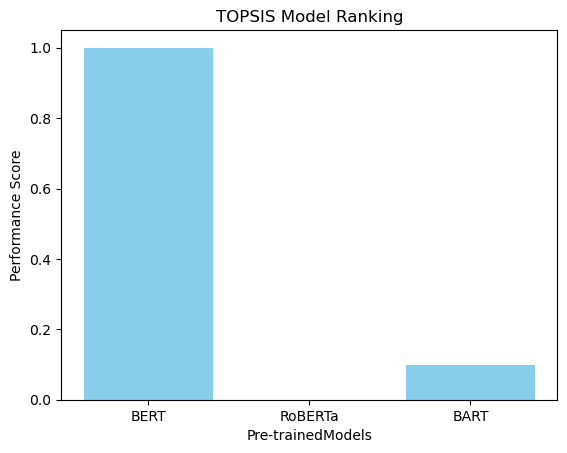

In [25]:
# Plot the performance scores (Higher scores = better models)
plt.bar(pretrained_models, performance_score, color='skyblue')
plt.xlabel('Pre-trainedModels')
plt.ylabel('Performance Score')
plt.title('TOPSIS Model Ranking')
plt.show()